# Install dependencies

In [ ]:
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00


# Importing Libraries

In [ ]:
import os, time, copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import timm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Load Preprocessed Dataset

Function to get a dataset, its dataloaders, and number of classes

**Args:**
- name (str): The name of the dataset ('mnist', 'fmnist', 'fashionmnist', 'cifar10')
- batch_size (int): The desired batch size for the dataloaders
- data_dir (str): The directory to store/load the dataset (defaults to './data')

**Returns:**
- tuple: (train_loader, val_loader, num_classes)

In [ ]:
def get_dataset(
    name: str,
    batch_size: int,
    data_dir: str = './data',
    train_fraction: float = 0.5
):
    """
    Loads MNIST, but uses only a fraction of the training set for faster iterations.

    Args:
        name (str): Dataset name; only 'mnist' is supported.
        batch_size (int): Batch size.
        data_dir (str): Directory to download/store data.
        train_fraction (float): Fraction of train samples to use (0 < frac ≤ 1).

    Returns:
        train_loader, val_loader, in_channels, num_classes
    """
    if name.lower() != 'fmnist':   # Convert the dataset name to lowercase and check it for 'fmnist'
        raise ValueError(f"Unsupported dataset: {name}")

    # Define a sequence of transformations to apply to FashionMNIST images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),    # Resize images to 224x224 pixels
        transforms.ToTensor(),    # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,))    # Normalize pixel values using dataset's mean and std
    ])

    num_classes = 10
    in_channels = 1
    Dataset = torchvision.datasets.FashionMNIST

    # Load full datasets
    full_train = Dataset(root=data_dir, train=True, download=True, transform=transform)
    val_ds     = Dataset(root=data_dir, train=False, download=True, transform=transform)

    # Subsample the train set
    if not (0 < train_fraction <= 1):
        raise ValueError("train_fraction must be in (0, 1].")
    if train_fraction < 1.0:
        n_total = len(full_train)
        n_sub   = int(n_total * train_fraction)
        # Shuffle indices and select subset
        indices = torch.randperm(n_total)[:n_sub].tolist()
        train_ds = Subset(full_train, indices)
    else:
        train_ds = full_train

    # DataLoader settings optimized for GPU usage
    loader_kwargs = {
        'batch_size': batch_size,
        'pin_memory': True,
        'persistent_workers': True,
        'num_workers': min(8, torch.get_num_threads()),
        'prefetch_factor': 2,
    }

    train_loader = DataLoader(train_ds, shuffle=True, **loader_kwargs)    # Create a DataLoader for the training set
    val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)   # Create a DataLoader for the validation/test set

    return train_loader, val_loader, in_channels, num_classes

# Model Factory

Function to get a neural network model instance

**Args:**
- name (str): The name of the model ('lenet5', 'alexnet', 'resnet', etc.)
- num_classes (int): The number of output classes for the classification layer
- pretrained (bool): Whether to load pretrained weights (defaults to False)

**Returns:**
- torch.nn.Module: An instance of the requested model

In [ ]:
import torch.nn as nn
import torchvision.models as tv_models
import timm

# (1) LeNet5 definition (unchanged)
class LeNet5(nn.Module):
    def __init__(self, in_ch: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 6, 5), nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5), nn.Tanh(),
            nn.AvgPool2d(2),
            nn.AdaptiveAvgPool2d((5, 5)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Tanh(),
            nn.Linear(120, 84), nn.Tanh(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))


# (2) Extended model factory for various architectures
def get_model(
    name: str,
    in_ch: int,
    num_classes: int,
    pretrained: bool = False
) -> nn.Module:
    """
    Returns one of: lenet5, alexnet, googlenet, vgg16, resnet18, xception, senet.
    """
    name = name.lower()

    # 1) Custom LeNet5
    if name == 'lenet5':
        return LeNet5(in_ch, num_classes)

    # 2) TorchVision models
    tv_specs = {
        'alexnet':   tv_models.alexnet,
        'googlenet': lambda pretrained: tv_models.googlenet(pretrained=pretrained, aux_logits=False),
        'vgg16':     tv_models.vgg16,
    }
    if name in tv_specs:
        builder = tv_specs[name]
        model = builder(pretrained) if name != 'googlenet' else builder(pretrained)

        # Adjust first conv for non-3-channel inputs
        if in_ch != 3:
            if name in ('alexnet', 'vgg16'):
                layer = model.features[0]
                model.features[0] = nn.Conv2d(
                    in_ch, layer.out_channels,
                    kernel_size=layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding,
                    bias=(layer.bias is not None)
                )
            elif name == 'googlenet':
                layer = model.conv1.conv
                model.conv1 = nn.Conv2d(
                    in_ch, layer.out_channels,
                    kernel_size=layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding,
                    bias=(layer.bias is not None)
                )

        # Replace classifier/fc
        if name in ('alexnet', 'vgg16'):
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        elif name == 'googlenet':
            model.fc = nn.Linear(model.fc.in_features, num_classes)

        return model

    # 3) Timm models
    timm_map = {
        'resnet18': 'resnet18',
        'xception': 'xception41',
        'senet':    'senet154',
    }
    if name in timm_map:
        return timm.create_model(
            timm_map[name],
            pretrained=pretrained,
            in_chans=in_ch,
            num_classes=num_classes
        )

    # 4) Unknown model
    valid = ['lenet5', 'alexnet', 'googlenet', 'vgg16', 'resnet18', 'xception', 'senet']
    raise ValueError(f"Invalid model '{name}'. Choose from {valid}.")

# Train / Eval Functions

In [ ]:
# Function to train the model for a single epoch
def train_one_epoch(
    model: nn.Module,
    device: torch.device,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: torch.cuda.amp.GradScaler = None,
    use_amp: bool = True):

    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The model to train.
        device (torch.device): Device to use ('cuda' or 'cpu').
        loader (DataLoader): DataLoader providing training data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.

    Returns:
        float: Average training loss over the epoch.
    """

    model.train()       # Set the model to training mode (enables dropout, batchnorm updates, etc.)
    total_loss = 0.0    # Initialize variable to accumulate loss over the epoch

    # If no scaler provided, turn off AMP
    use_amp = use_amp and (scaler is not None)

    # Iterate over the training data batches using the provided loader, tqdm adds a progress bar for the loop
    for X, y in tqdm(loader, desc='Training', leave=False):
      X, y = X.to(device), y.to(device)   # Move input features (X) and labels (y) to the specified device
      # Zero the gradients of the optimizer before computing gradients for the current batch
      optimizer.zero_grad()
      # Forward + backward
      if use_amp:
        with torch.amp.autocast('cuda'):
          # Forward pass: Compute predicted outputs by passing inputs through the model
          outputs = model(X)
          # Calculate the loss between predicted outputs and true labels
          loss = criterion(outputs, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
      else:
        # Forward pass: Compute predicted outputs by passing inputs through the model
        outputs = model(X)
        # Calculate the loss between predicted outputs and true labels
        loss = criterion(outputs, y)
        loss.backward() # Backward pass: Compute gradient of the loss with respect to model parameters
        optimizer.step() # Optimizer step: Update the model's parameters using the computed gradients

      # Accumulate the batch loss, scaled by the number of samples in the batch loss.item() gets the scalar value of the loss tensor
      total_loss += loss.item() * X.size(0)

    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss # Return the average training loss for the epoch

# Function to evaluate the model on a dataset (validation or test)
def evaluate(
    model: nn.Module,
    device: torch.device,
    loader: DataLoader,
    criterion: nn.Module
):
    """
    Evaluates the model on a validation or test set.

    Args:
        model (nn.Module): The model to evaluate.
        device (torch.device): Device to use ('cuda' or 'cpu').
        loader (DataLoader): DataLoader providing evaluation data.
        criterion (nn.Module): Loss function.

    Returns:
        tuple: Average loss, accuracy, precision, recall, F1-score, (true targets, predictions).
    """
    model.eval()    # Set the model to evaluation mode (disables dropout, uses running stats for batchnorm, etc.)
    total_loss = 0.0    # Initialize variable to accumulate loss
    # all_preds, all_targets = [], []   # Lists to store all predictions and true labels for metric calculation

    # Pre-allocate tensors
    all_preds = torch.empty((0,), dtype=torch.long, device='cpu')
    all_targets = torch.empty((0,), dtype=torch.long, device='cpu')

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Iterate over the evaluation data batches using the provided loader
        # tqdm adds a progress bar for the loop
        for X, y in tqdm(loader, desc='Evaluating', leave=False):
            X, y = X.to(device), y.to(device) # Move input features (X) and labels (y) to the specified device

            # Forward pass: Compute predicted outputs
            out = model(X)

            # Calculate the batch loss and accumulate it
            batch_loss = criterion(out, y)
            total_loss += batch_loss.item() * X.size(0)

            # Get the predicted class index for each sample in the batch
            # argmax(dim=1) finds the index of the max value along dimension 1 (the class dimension)
            preds = out.argmax(dim=1)

            preds = out.argmax(dim=1).cpu()
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_targets = torch.cat((all_targets, y.cpu()), dim=0)

    avg_loss = total_loss / len(loader.dataset)   # Calculate the average loss over the dataset
    y_true = all_targets.numpy()
    y_pred = all_preds.numpy()

    # Calculate evaluation metrics using scikit-learn
    acc = accuracy_score(y_true, y_pred) # Overall accuracy

    # Precision, Recall, F1-score. 'weighted' averages metrics for each class, weighted by support.
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Return the calculated metrics and the full lists of targets and predictions
    return avg_loss, acc, prec, rec, f1, (y_true, y_pred)

# Plotting Utility

Function to plot training/validation loss and validation accuracy over epochs

**Args:**
- history (dict): Dictionary containing lists of metrics like 'train_loss', 'val_loss', 'val_acc'
- title (str): A string to use as a base for the plot titles

In [ ]:
def plot_metrics(history, title):
    # Determine the number of epochs from the length of the training loss list
    epochs = len(history['train_loss'])

    # --- Plot Loss ---
    plt.figure(); # Create a new figure for the loss plot
    # Plot the training loss
    plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
    # Plot the validation loss
    plt.plot(range(1, epochs+1), history['val_loss'],   label='Val Loss')
    # Set the title for the loss plot
    plt.title(f'{title} Loss');
    # Label the x-axis
    plt.xlabel('Epoch');
    # Display the legend
    plt.legend();
    # Show the loss plot
    plt.show()

    # --- Plot Accuracy ---
    plt.figure(); # Create a new figure for the accuracy plot
    # Plot the validation accuracy
    plt.plot(range(1, epochs+1), history['val_acc'],   label='Val Acc')
    # Set the title for the accuracy plot
    plt.title(f'{title} Accuracy');
    # Label the x-axis
    plt.xlabel('Epoch');
    # Display the legend
    plt.legend();
    # Show the accuracy plot
    plt.show()

# Experiment Runner

Main function to run a training and evaluation experiment

**Args:**
- dataset (str): Name of the dataset to use (default: 'fmnist')
- model_name (str): Name of the model architecture (default: None)
- pretrained (bool): Whether to use a pretrained model (default: False)
- epochs (int): Number of training epochs (default: 5)
- batch_size (int): Batch size for data loaders (default: 64)
- lr (float): Learning rate for the optimizer (default: 0.01)

**Returns:**
- torch.nn.Module: The trained model

In [ ]:
def run_experiment(
    dataset='fmnist',
    model_name=None,
    pretrained: bool = False,
    epochs: int = 5,
    batch_size: int = 64,
    lr: float = 0.01,
    train_fraction = 0.5,
    save_dir: str = './checkpoints',
    use_amp: bool = True):
    """
    Run a full training experiment:
     - Loads data for `dataset`
     - Instantiates `model_name` (with `pretrained` weights) using in_ch from data
     - Trains for `epochs` epochs
     - Saves best model based on validation accuracy
     - Plots training/validation metrics
     - Prints a final classification report

    Returns the best-trained model (moved to CPU).
    """

    if not model_name:
      raise ValueError("`model_name` must be specified")

    os.makedirs(save_dir, exist_ok=True)
    # Device setup, determine the device to use (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    torch.backends.cudnn.benchmark = True

    # Data loaders
    # Data loaders
    train_loader, val_loader, in_ch, num_classes = get_dataset(dataset, batch_size, data_dir='./data', train_fraction=train_fraction)
    print(f"Detected input channels: {in_ch}")

    # Model instantiation
    model = get_model(model_name, in_ch, num_classes, pretrained=pretrained).to(device)
    print(f"Model '{model_name}' instantiated with pretrained={pretrained} and moved to {device}.")

    # Optimizer, loss, scheduler, AMP scaler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=='cuda') else None

    # History containers
    history = {
        'train_loss': [], 'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    best_acc = 0.0
    best_model_wts = None
    best_ckpt_path = None

    # Training loop
    for epoch in range(1, epochs + 1):
        print(f"\n====Epoch {epoch}/{epochs}====")
        train_loss = train_one_epoch(model, device, train_loader, criterion, optimizer, scaler=scaler, use_amp=use_amp)
        val_loss, val_acc, val_prec, val_rec, val_f1, (y_true, y_pred) = evaluate(model, device, val_loader, criterion)

        scheduler.step()  # for StepLR

        # Record history logs
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Checkpoint best
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            ckpt_name = f"{dataset}_{model_name}_best.pth"
            best_ckpt_path = os.path.join(save_dir, ckpt_name)
            torch.save(best_model_wts, best_ckpt_path)
            print(f"[INFO] New best (Acc={best_acc:.4f}) → saved to {best_ckpt_path}")

    # --- Load & evaluate best model ---
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    model = model.cpu()

    # Re‐evaluate on val set to get final preds/targets
    _, _, _, _, _, (y_true, y_pred) = evaluate(model, torch.device('cpu'), val_loader, criterion)

    # --- Plot & report ---
    plot_metrics(history, title=f"{dataset} - {model_name}")
    print("\nFinal Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    return model

# Example Usage

## lenet5

Training lenet5 on FMNIST Dataset...
Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.1MB/s]


Detected input channels: 1


<ipython-input-25-5b4538de3186>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=='cuda') else None


Model 'lenet5' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 1.7856 | Val Loss: 1.2612 | Val Acc: 0.6197 | Val F1: 0.5683
[INFO] New best (Acc=0.6197) → saved to ./checkpoints/fmnist_lenet5_best.pth

====Epoch 2/5====


Train Loss: 1.0523 | Val Loss: 0.9147 | Val Acc: 0.6890 | Val F1: 0.6693
[INFO] New best (Acc=0.6890) → saved to ./checkpoints/fmnist_lenet5_best.pth

====Epoch 3/5====


Train Loss: 0.8292 | Val Loss: 0.7875 | Val Acc: 0.7145 | Val F1: 0.7054
[INFO] New best (Acc=0.7145) → saved to ./checkpoints/fmnist_lenet5_best.pth

====Epoch 4/5====


Train Loss: 0.7356 | Val Loss: 0.7255 | Val Acc: 0.7381 | Val F1: 0.7294
[INFO] New best (Acc=0.7381) → saved to ./checkpoints/fmnist_lenet5_best.pth

====Epoch 5/5====


Train Loss: 0.6813 | Val Loss: 0.6817 | Val Acc: 0.7516 | Val F1: 0.7458
[INFO] New best (Acc=0.7516) → saved to ./checkpoints/fmnist_lenet5_best.pth


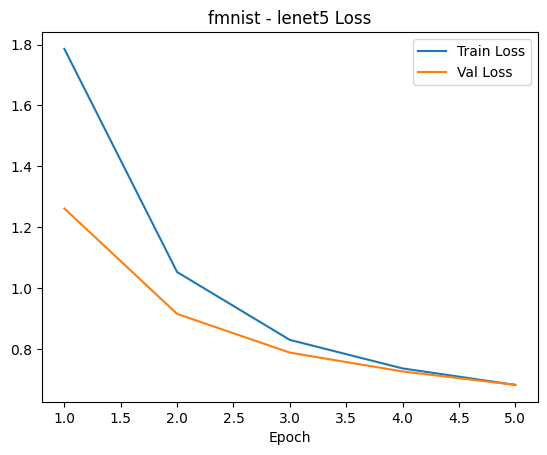

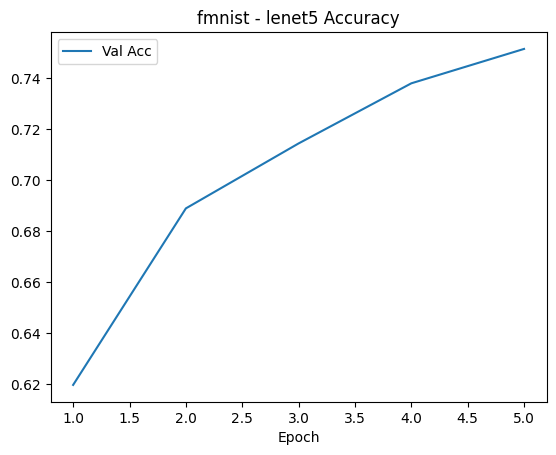


Final Classification Report:
              precision    recall  f1-score   support

           0     0.7265    0.7730    0.7490      1000
           1     0.9061    0.8780    0.8918      1000
           2     0.6090    0.5980    0.6034      1000
           3     0.7126    0.7810    0.7452      1000
           4     0.5760    0.6710    0.6199      1000
           5     0.8962    0.8630    0.8793      1000
           6     0.3609    0.2530    0.2975      1000
           7     0.8718    0.8430    0.8571      1000
           8     0.9206    0.9160    0.9183      1000
           9     0.8561    0.9400    0.8961      1000

    accuracy                         0.7516     10000
   macro avg     0.7436    0.7516    0.7458     10000
weighted avg     0.7436    0.7516    0.7458     10000

Finished training lenet5 on FMNIST Dataset.


In [ ]:
model_name = 'lenet5'
print(f"Training {model_name} on FMNIST Dataset...")

# Enable AMP automatically if GPU is available
use_amp = torch.cuda.is_available()

run_experiment(
    model_name='lenet5',
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001,
    train_fraction=0.5)
print(f"Finished training {model_name} on FMNIST Dataset.")

## alexnet

Training alexnet on FMNIST Dataset...
Using device: cuda
Detected input channels: 1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-25-5b4538de3186>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=='cuda') else None


Model 'alexnet' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 2.3013 | Val Loss: 2.2979 | Val Acc: 0.1000 | Val F1: 0.0182
[INFO] New best (Acc=0.1000) → saved to ./checkpoints/fmnist_alexnet_best.pth

====Epoch 2/5====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 2.0745 | Val Loss: 1.0494 | Val Acc: 0.6244 | Val F1: 0.5757
[INFO] New best (Acc=0.6244) → saved to ./checkpoints/fmnist_alexnet_best.pth

====Epoch 3/5====


Train Loss: 0.8709 | Val Loss: 0.7092 | Val Acc: 0.7391 | Val F1: 0.7159
[INFO] New best (Acc=0.7391) → saved to ./checkpoints/fmnist_alexnet_best.pth

====Epoch 4/5====


Train Loss: 0.6678 | Val Loss: 0.5890 | Val Acc: 0.7824 | Val F1: 0.7832
[INFO] New best (Acc=0.7824) → saved to ./checkpoints/fmnist_alexnet_best.pth

====Epoch 5/5====


Train Loss: 0.5819 | Val Loss: 0.5397 | Val Acc: 0.7968 | Val F1: 0.7876
[INFO] New best (Acc=0.7968) → saved to ./checkpoints/fmnist_alexnet_best.pth


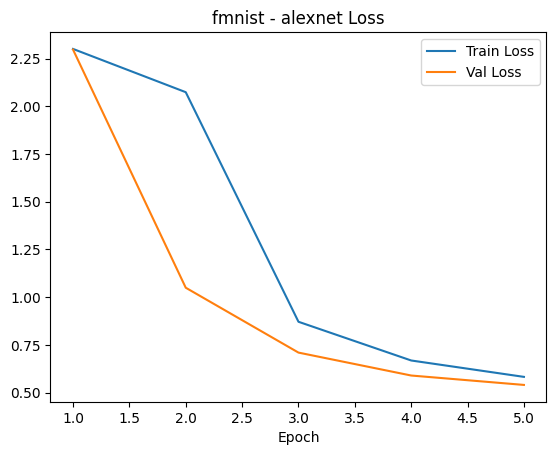

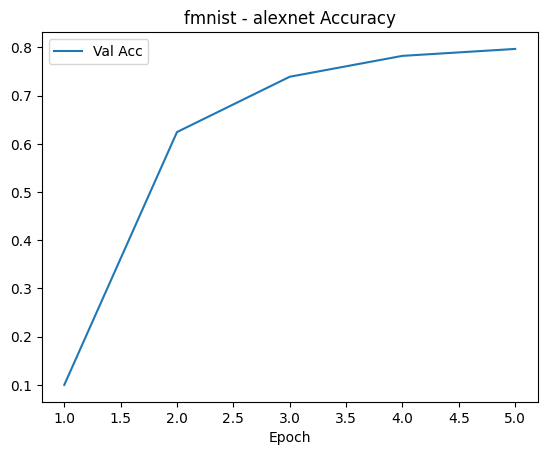


Final Classification Report:
              precision    recall  f1-score   support

           0     0.7639    0.7570    0.7604      1000
           1     0.9323    0.9500    0.9411      1000
           2     0.6255    0.6930    0.6575      1000
           3     0.7375    0.8680    0.7974      1000
           4     0.6394    0.7590    0.6941      1000
           5     0.9143    0.9280    0.9211      1000
           6     0.5494    0.2780    0.3692      1000
           7     0.9234    0.8560    0.8884      1000
           8     0.9471    0.9130    0.9297      1000
           9     0.8734    0.9660    0.9174      1000

    accuracy                         0.7968     10000
   macro avg     0.7906    0.7968    0.7876     10000
weighted avg     0.7906    0.7968    0.7876     10000

Finished training alexnet on FMNIST Dataset.


In [ ]:
# Train alexnet model on each datasets
model_name = 'alexnet'
print(f"Training {model_name} on FMNIST Dataset...")

# Enable AMP automatically if GPU is available
use_amp = torch.cuda.is_available()

run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001,
    use_amp=use_amp,
    train_fraction=0.5)
print(f"Finished training {model_name} on FMNIST Dataset.")

## googlenet

Training googlenet on FMNIST Dataset...
Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.30MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 149kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy

Detected input channels: 1


<ipython-input-8-5b4538de3186>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=='cuda') else None


Model 'googlenet' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 0.5904 | Val Loss: 0.5569 | Val Acc: 0.8075 | Val F1: 0.7858
[INFO] New best (Acc=0.8075) → saved to ./checkpoints/fmnist_googlenet_best.pth

====Epoch 2/5====


Train Loss: 0.3149 | Val Loss: 0.4811 | Val Acc: 0.8294 | Val F1: 0.8290
[INFO] New best (Acc=0.8294) → saved to ./checkpoints/fmnist_googlenet_best.pth

====Epoch 3/5====


Train Loss: 0.2604 | Val Loss: 0.3700 | Val Acc: 0.8728 | Val F1: 0.8707
[INFO] New best (Acc=0.8728) → saved to ./checkpoints/fmnist_googlenet_best.pth

====Epoch 4/5====


Train Loss: 0.2277 | Val Loss: 0.2731 | Val Acc: 0.8990 | Val F1: 0.9003
[INFO] New best (Acc=0.8990) → saved to ./checkpoints/fmnist_googlenet_best.pth

====Epoch 5/5====


Train Loss: 0.2016 | Val Loss: 0.2471 | Val Acc: 0.9117 | Val F1: 0.9121
[INFO] New best (Acc=0.9117) → saved to ./checkpoints/fmnist_googlenet_best.pth


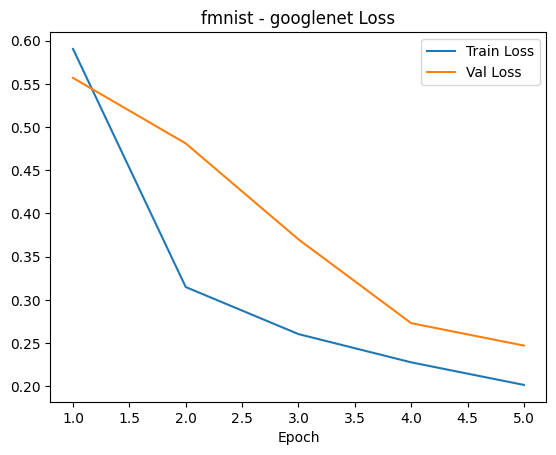

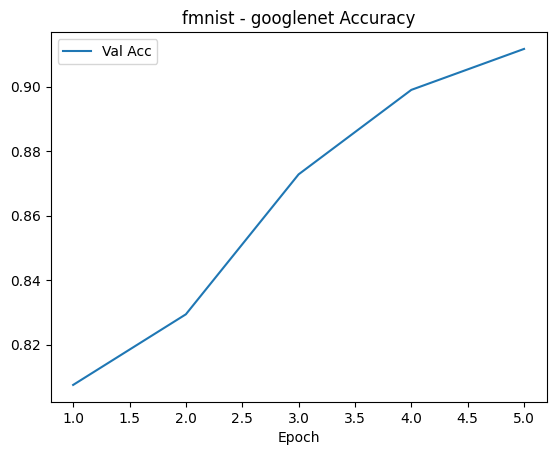


Final Classification Report:
              precision    recall  f1-score   support

           0     0.8796    0.8040    0.8401      1000
           1     0.9949    0.9820    0.9884      1000
           2     0.8836    0.8730    0.8783      1000
           3     0.9101    0.9210    0.9155      1000
           4     0.8369    0.8720    0.8541      1000
           5     0.9879    0.9760    0.9819      1000
           6     0.7250    0.7700    0.7468      1000
           7     0.9495    0.9770    0.9630      1000
           8     0.9879    0.9770    0.9824      1000
           9     0.9757    0.9650    0.9703      1000

    accuracy                         0.9117     10000
   macro avg     0.9131    0.9117    0.9121     10000
weighted avg     0.9131    0.9117    0.9121     10000

Finished training googlenet on FMNIST Dataset.


In [ ]:
# Train googlenet model on each datasets
model_name = 'googlenet'
print(f"Training {model_name} on FMNIST Dataset...")

# Enable AMP automatically if GPU is available
use_amp = torch.cuda.is_available()

run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001,
    use_amp=use_amp,
    train_fraction=0.5)
print(f"Finished training {model_name} on FMNIST Dataset.")

## resnet

Training resnet18 on FMNIST Dataset...
Using device: cuda
Detected input channels: 1


<ipython-input-8-5b4538de3186>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=='cuda') else None


Model 'resnet18' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 1.8176 | Val Loss: 1.5262 | Val Acc: 0.5090 | Val F1: 0.4877
[INFO] New best (Acc=0.5090) → saved to ./checkpoints/fmnist_resnet18_best.pth

====Epoch 2/5====


Train Loss: 1.3446 | Val Loss: 1.2168 | Val Acc: 0.6196 | Val F1: 0.6074
[INFO] New best (Acc=0.6196) → saved to ./checkpoints/fmnist_resnet18_best.pth

====Epoch 3/5====


Train Loss: 1.1310 | Val Loss: 1.0950 | Val Acc: 0.6409 | Val F1: 0.6284
[INFO] New best (Acc=0.6409) → saved to ./checkpoints/fmnist_resnet18_best.pth

====Epoch 4/5====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.0165 | Val Loss: 1.8308 | Val Acc: 0.3225 | Val F1: 0.2396

====Epoch 5/5====


Train Loss: 0.9287 | Val Loss: 0.9861 | Val Acc: 0.6653 | Val F1: 0.6579
[INFO] New best (Acc=0.6653) → saved to ./checkpoints/fmnist_resnet18_best.pth


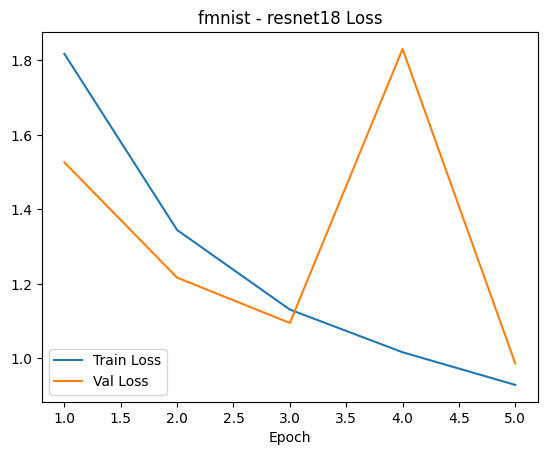

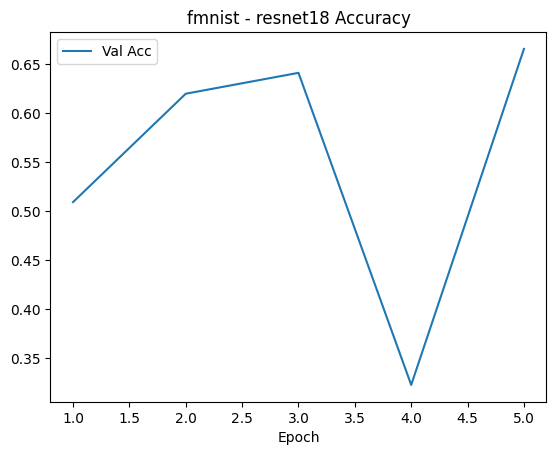


Final Classification Report:
              precision    recall  f1-score   support

           0     0.5780    0.7820    0.6647      1000
           1     0.9323    0.8950    0.9133      1000
           2     0.5772    0.5830    0.5801      1000
           3     0.6654    0.7200    0.6916      1000
           4     0.5477    0.4880    0.5161      1000
           5     0.5671    0.9590    0.7127      1000
           6     0.4094    0.2800    0.3325      1000
           7     0.8630    0.4660    0.6052      1000
           8     0.8803    0.7060    0.7836      1000
           9     0.7842    0.7740    0.7791      1000

    accuracy                         0.6653     10000
   macro avg     0.6805    0.6653    0.6579     10000
weighted avg     0.6805    0.6653    0.6579     10000

Finished training resnet18 on FMNIST Dataset.


In [10]:
# Train resnet model on each datasets
model_name = 'resnet18'
print(f"Training {model_name} on FMNIST Dataset...")

# Enable AMP automatically if GPU is available
use_amp = torch.cuda.is_available()

run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001,
    use_amp=use_amp,
    train_fraction=0.5)
print(f"Finished training {model_name} on FMNIST Dataset.")

## xception

Training xception on FMNIST Dataset...
Using device: cuda
Detected input channels: 1


<ipython-input-8-5b4538de3186>:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=='cuda') else None


Model 'xception' instantiated with pretrained=False and moved to cuda.

====Epoch 1/5====


Train Loss: 1.3719 | Val Loss: 0.7982 | Val Acc: 0.7154 | Val F1: 0.7128
[INFO] New best (Acc=0.7154) → saved to ./checkpoints/fmnist_xception_best.pth

====Epoch 2/5====


Train Loss: 0.6497 | Val Loss: 0.5558 | Val Acc: 0.7981 | Val F1: 0.7959
[INFO] New best (Acc=0.7981) → saved to ./checkpoints/fmnist_xception_best.pth

====Epoch 3/5====


Train Loss: 0.4855 | Val Loss: 0.4723 | Val Acc: 0.8240 | Val F1: 0.8194
[INFO] New best (Acc=0.8240) → saved to ./checkpoints/fmnist_xception_best.pth

====Epoch 4/5====


Train Loss: 0.3960 | Val Loss: 0.4184 | Val Acc: 0.8485 | Val F1: 0.8440
[INFO] New best (Acc=0.8485) → saved to ./checkpoints/fmnist_xception_best.pth

====Epoch 5/5====


Train Loss: 0.3298 | Val Loss: 0.3740 | Val Acc: 0.8630 | Val F1: 0.8598
[INFO] New best (Acc=0.8630) → saved to ./checkpoints/fmnist_xception_best.pth


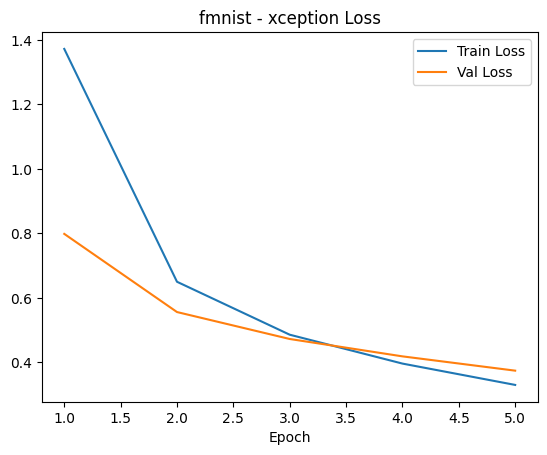

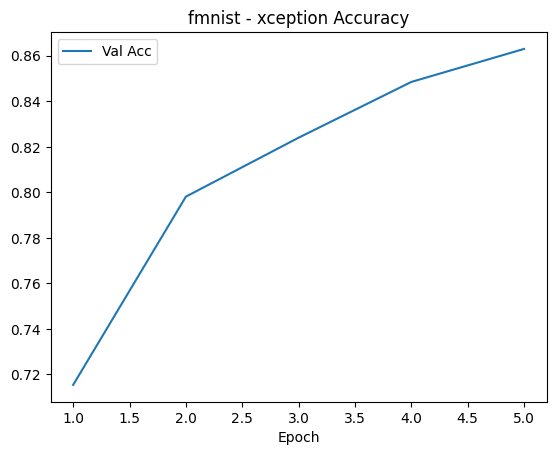


Final Classification Report:
              precision    recall  f1-score   support

           0     0.7705    0.8630    0.8142      1000
           1     0.9886    0.9570    0.9726      1000
           2     0.7346    0.8580    0.7915      1000
           3     0.8408    0.9030    0.8708      1000
           4     0.7923    0.7440    0.7674      1000
           5     0.9801    0.9380    0.9586      1000
           6     0.6809    0.4930    0.5719      1000
           7     0.9155    0.9640    0.9391      1000
           8     0.9639    0.9610    0.9624      1000
           9     0.9490    0.9490    0.9490      1000

    accuracy                         0.8630     10000
   macro avg     0.8616    0.8630    0.8598     10000
weighted avg     0.8616    0.8630    0.8598     10000

Finished training xception on FMNIST Dataset.


In [11]:
# Train resnet model on each datasets
model_name = 'xception'
print(f"Training {model_name} on FMNIST Dataset...")

# Enable AMP automatically if GPU is available
use_amp = torch.cuda.is_available()

run_experiment(
    model_name=model_name,
    pretrained=False,
    epochs=5,
    batch_size=64,
    lr=0.001,
    use_amp=use_amp,
    train_fraction=0.5)
print(f"Finished training {model_name} on FMNIST Dataset.")